In [1]:
import sys
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
from joypy import joyplot

sys.path.append("../")
from calculus_path_mod.term_engine import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms import num_comparison, nat_numbers, arithm_ops, combinators, pairs, logic
from calculus_path_mod.terms.pseudonym import *

from calculus_path_mod.json_serialization import load_terms
from fitter import Fitter, get_common_distributions
from calculus_utils.drawing import draw_steps_displot

# Load Terms filtered LO

In [2]:
terms_LO = load_terms("../tests_11_retests/terms_210_filtered_LO.dat")
# terms_RI = load_terms("../tests_11_retests/terms_210_filtered_RI.dat")

# Collect normalization process data for LO-strategy & LI-strategy with tLO

In [3]:
def gen_norm_data(terms_list, strategy):
    steps = []
    for term in tqdm(terms_list):
        try:
            norm_data = term.normalize_with_params(strategy)
            steps.append(norm_data)
        except Exception:
            steps.append(None)
    return steps

In [4]:
data_LO = gen_norm_data(terms_LO, LOStrategy())
data_LI = gen_norm_data(terms_LO, LIStrategy())

100%|██████████| 226/226 [11:06<00:00,  2.95s/it] 


In [119]:
coords_steps = [(len(step_LO["redexes"]) - 1, len(step_LI["redexes"]) - 1) for step_LO, step_LI in zip(data_LO, data_LI) if step_LO and step_LI]
# coords_steps = [(x, y) for x, y in coords_steps if x < 40 and y < 40]
coords_steps = np.array(coords_steps)
# print(coords_steps)

In [120]:
on_diag = len(list([(x, y) for x, y in coords_steps if x == y]))
top_diag = len(list([(x, y) for x, y in coords_steps if x < y]))
bottom_diag = len(list([(x, y) for x, y in coords_steps if x > y]))

print(on_diag, top_diag, bottom_diag)

44 155 25


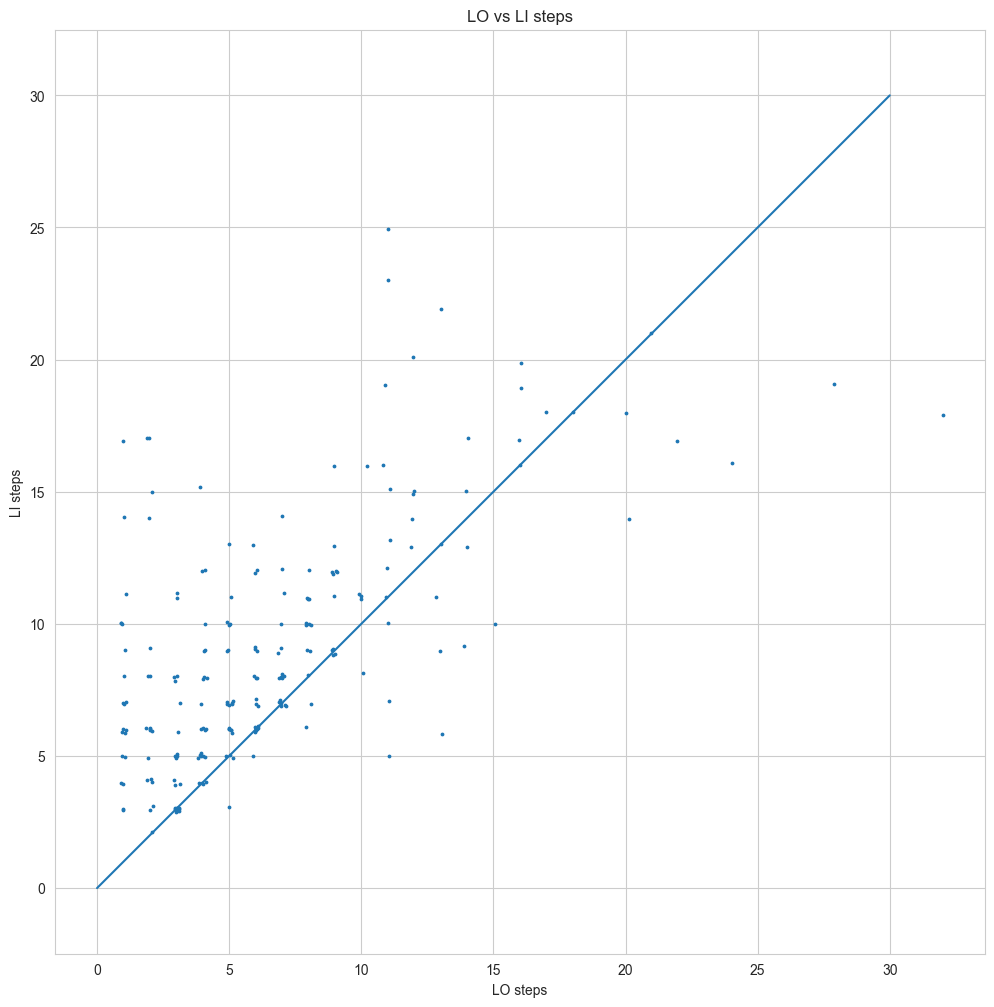

In [118]:
def draw_dots_clouds(
        x_records, y_records,
        x_label="x", y_label="y", title="",
        x_limit=50, y_limit=50,
        is_rand=True
):
    x_clean, y_clean = [], []
    for inx in range(len(x_records)):
        if not (x_records[inx] > x_limit or y_records[inx] > y_limit):
            x_clean.append(x_records[inx] + np.random.normal(0, 0.07, size=1)[0] if is_rand else x_records[inx])
            y_clean.append(y_records[inx] + np.random.normal(0, 0.07, size=1)[0] if is_rand else y_records[inx])

    plt.figure(figsize=(12, 12))
    plt.scatter(x_clean, y_clean, s=3)
    plt.plot([0, 30], [0, 30])
    plt.axis("equal")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


draw_dots_clouds(
    coords_steps[:,0], coords_steps[:,1],
    x_label="LO steps", y_label="LI steps", title="LO vs LI steps"
)

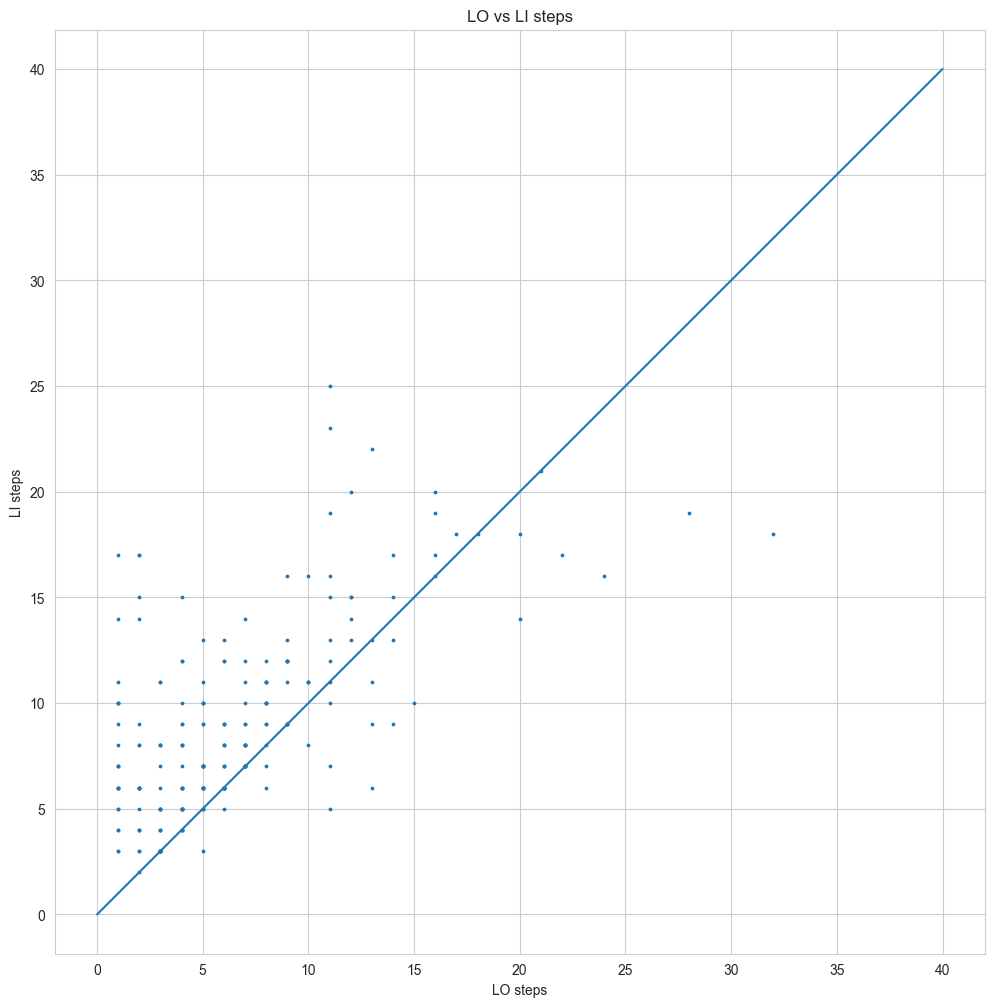

In [113]:
plt.figure(figsize=(12, 12))
plt.plot([0, 40], [0, 40])
plt.scatter(coords_steps[:,0], coords_steps[:,1], s=3)
plt.axis("equal")
plt.xlabel("LO steps")
plt.ylabel("LI steps")
plt.title("LO vs LI steps")
plt.show()

# Plot Simple Lines plot

In [ ]:
# "vertices"
# "redexes"
# "redex_depths"
# "redex_indexes"
# "heights"
# "widths"
# "steps_time"

In [34]:
def get_expected_steps(steps):
    steps = list(filter(lambda x: x != float("inf"), steps))
    steps = list(filter(lambda x: x != 0, steps))
    if len(steps) == 0:
        return 0

    distributions = get_common_distributions()
    distributions.remove("expon")
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    return result

In [35]:
data_vis_LO = {"step": list(range(max([len(record["vertices"]) for record in data_LO]))),
               "count_terms": [], "vertices": [], "redexes": [], "redex_depths": [],
               "redex_indexes": [], "heights": [], "widths": [], "steps_time": []}

for step_no in data_vis_LO["step"]:
    count_terms = 0
    tmp_step_param_dct = {"vertices": [], "redexes": [], "redex_depths": [], "redex_indexes": [], "heights": [],
                          "widths": [], "steps_time": []}
    for term_params in data_LO:
        if step_no < len(term_params["vertices"]):
            count_terms += 1
            for key_ in tmp_step_param_dct.keys():
                tmp_step_param_dct[key_].append(term_params[key_][step_no])

    for key_ in tmp_step_param_dct.keys():
        expected_val = get_expected_steps(tmp_step_param_dct[key_])
        data_vis_LO[key_].append(expected_val)

    data_vis_LO["count_terms"].append(count_terms)

Fitting 9 distributions:   0%|          | 0/9 [00:00<?, ?it/s]SKIPPED cauchy distribution (taking more than 30 seconds)
SKIPPED chi2 distribution (taking more than 30 seconds)
Fitting 9 distributions:  22%|██▏       | 2/9 [00:00<00:00, 16.66it/s]SKIPPED gamma distribution (taking more than 30 seconds)
SKIPPED lognorm distribution (taking more than 30 seconds)
SKIPPED powerlaw distribution (taking more than 30 seconds)
SKIPPED norm distribution (taking more than 30 seconds)
SKIPPED rayleigh distribution (taking more than 30 seconds)
SKIPPED uniform distribution (taking more than 30 seconds)
SKIPPED exponpow distribution (taking more than 30 seconds)
Fitting 9 distributions:   0%|          | 0/9 [00:00<?, ?it/s]SKIPPED cauchy distribution (taking more than 30 seconds)
SKIPPED chi2 distribution (taking more than 30 seconds)
SKIPPED gamma distribution (taking more than 30 seconds)
SKIPPED lognorm distribution (taking more than 30 seconds)
Fitting 9 distributions:  44%|████▍     | 4/9 [00:0

In [42]:
data_vis_LI = {"step": list(range(max([len(record["vertices"]) for record in data_LO]))),
               "count_terms": [], "vertices": [], "redexes": [], "redex_depths": [],
               "redex_indexes": [], "heights": [], "widths": [], "steps_time": []}

for step_no in data_vis_LI["step"]:
    count_terms = 0
    tmp_step_param_dct = {"vertices": [], "redexes": [], "redex_depths": [], "redex_indexes": [], "heights": [],
                          "widths": [], "steps_time": []}
    for term_params in data_LI:
        if term_params and (step_no < len(term_params["vertices"])):
            count_terms += 1
            for key_ in tmp_step_param_dct.keys():
                tmp_step_param_dct[key_].append(term_params[key_][step_no])

    for key_ in tmp_step_param_dct.keys():
        expected_val = get_expected_steps(tmp_step_param_dct[key_])
        data_vis_LI[key_].append(expected_val)

    data_vis_LI["count_terms"].append(count_terms)

Fitting 9 distributions:   0%|          | 0/9 [00:00<?, ?it/s]SKIPPED cauchy distribution (taking more than 30 seconds)
SKIPPED chi2 distribution (taking more than 30 seconds)
Fitting 9 distributions:  22%|██▏       | 2/9 [00:00<00:00, 18.73it/s]SKIPPED powerlaw distribution (taking more than 30 seconds)
SKIPPED gamma distribution (taking more than 30 seconds)
SKIPPED rayleigh distribution (taking more than 30 seconds)
SKIPPED norm distribution (taking more than 30 seconds)
SKIPPED lognorm distribution (taking more than 30 seconds)
SKIPPED uniform distribution (taking more than 30 seconds)
SKIPPED exponpow distribution (taking more than 30 seconds)
Fitting 9 distributions:   0%|          | 0/9 [00:00<?, ?it/s]SKIPPED cauchy distribution (taking more than 30 seconds)
SKIPPED chi2 distribution (taking more than 30 seconds)
SKIPPED lognorm distribution (taking more than 30 seconds)
Fitting 9 distributions:  33%|███▎      | 3/9 [00:00<00:00, 27.39it/s]SKIPPED gamma distribution (taking mor

In [58]:
data_vis_LO["redex_depths"] = list([rec_ if rec_ > 0 else 0.0 for rec_ in data_vis_LO["redex_depths"]])
data_vis_LO["redex_indexes"] = list([rec_ if rec_ > 0 else 0.0 for rec_ in data_vis_LO["redex_indexes"]])

data_vis_LI["redex_depths"] = list([rec_ if rec_ > 0 else 0.0 for rec_ in data_vis_LI["redex_depths"]])
data_vis_LI["redex_indexes"] = list([rec_ if rec_ > 0 else 0.0 for rec_ in data_vis_LI["redex_indexes"]])

In [38]:
def plot_multi_lines(plt_data: dict, ):
    # Create separate subplots
    fig, ax_list = plt.subplots(len(plt_data.keys()), 1, figsize=(8, 10))

    # Plot the lines on each subplot
    for (key_, val_), ax_ in zip(plt_data.items(), ax_list):
        ax_.plot(range(len(val_)), val_, label=key_)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()


def plot_multi_multi_lines(plt_data: dict, ):
    # Create separate subplots
    fig, ax_list = plt.subplots(len(plt_data.keys()), 1, figsize=(8, 10))

    # Plot the lines on each subplot
    for (key_, data_), ax_ in zip(plt_data.items(), ax_list):
        for dkey_, val_ in data_.items():
            ax_.plot(range(len(val_)), val_, label=dkey_)
        ax_.set_title(key_)
        ax_.legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()

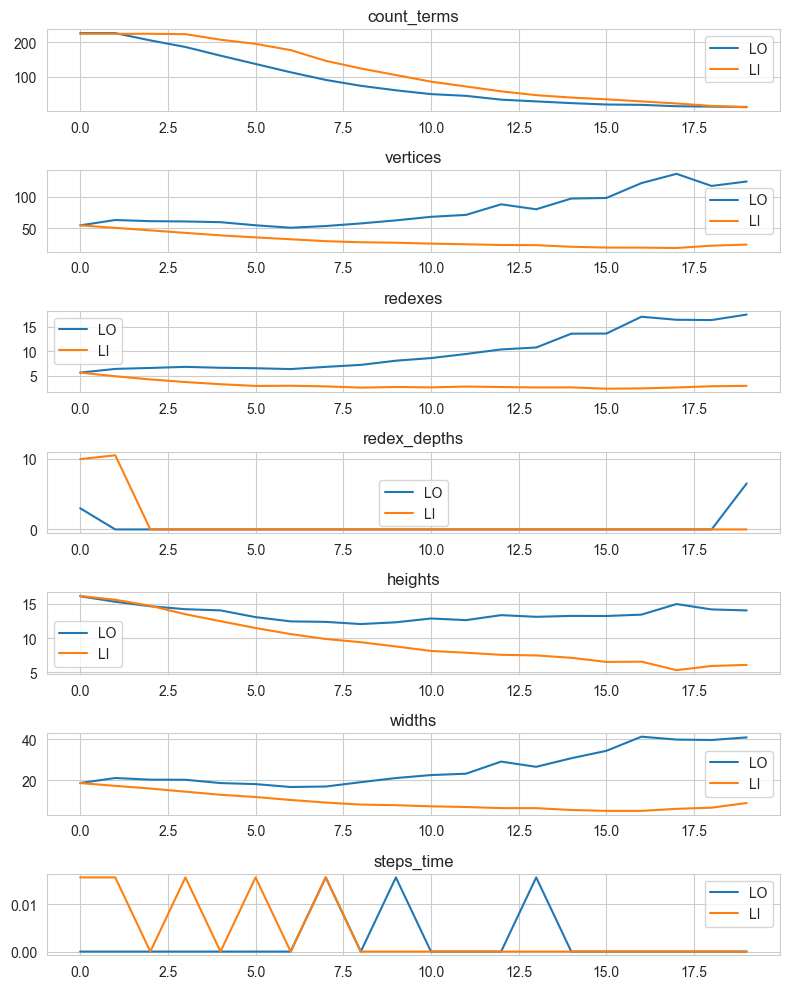

In [59]:
vis_df = {
    "count_terms": {
        "LO": data_vis_LO["count_terms"][:20],
        "LI": data_vis_LI["count_terms"][:20],
    },
    "vertices": {
        "LO": data_vis_LO["vertices"][:20],
        "LI": data_vis_LI["vertices"][:20],
    },
    "redexes": {
        "LO": data_vis_LO["redexes"][:20],
        "LI": data_vis_LI["redexes"][:20],
    },
    "redex_depths": {
        "LO": data_vis_LO["redex_depths"][:20],
        "LI": data_vis_LI["redex_depths"][:20],
    },
    "heights": {
        "LO": data_vis_LO["heights"][:20],
        "LI": data_vis_LI["heights"][:20],
    },
    "widths": {
        "LO": data_vis_LO["widths"][:20],
        "LI": data_vis_LI["widths"][:20],
    },
    "steps_time": {
        "LO": data_vis_LO["steps_time"][:20],
        "LI": data_vis_LI["steps_time"][:20],
    },
}
plot_multi_multi_lines(vis_df)

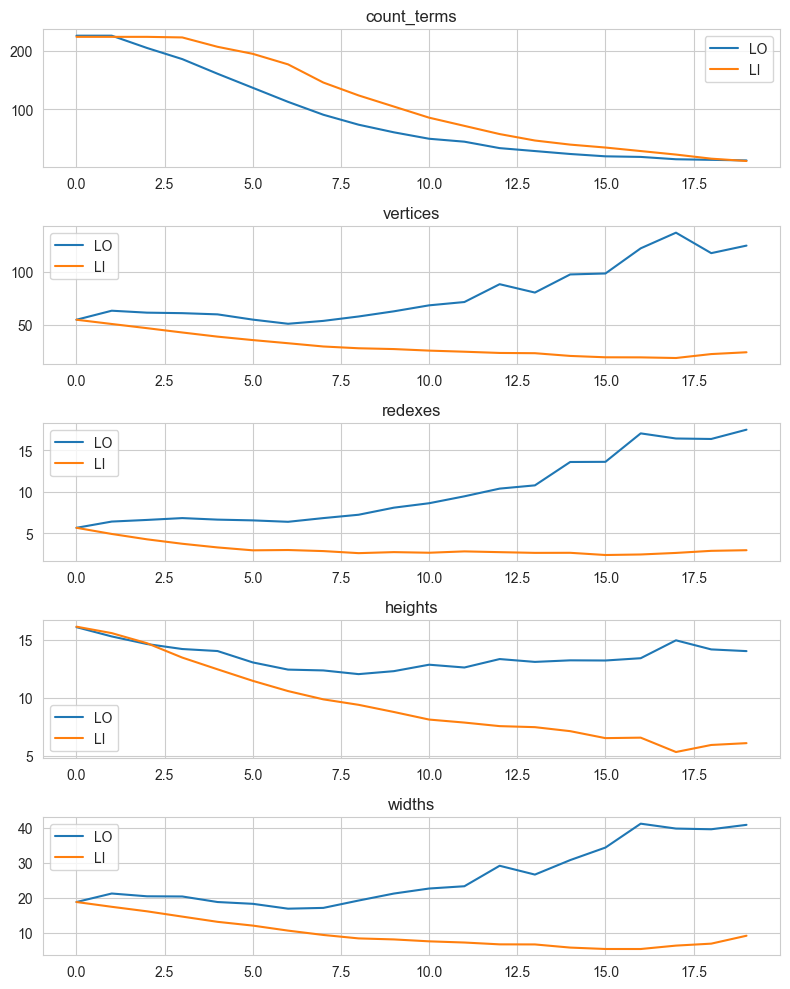

In [60]:
vis_df = {
    "count_terms": {
        "LO": data_vis_LO["count_terms"][:20],
        "LI": data_vis_LI["count_terms"][:20],
    },
    "vertices": {
        "LO": data_vis_LO["vertices"][:20],
        "LI": data_vis_LI["vertices"][:20],
    },
    "redexes": {
        "LO": data_vis_LO["redexes"][:20],
        "LI": data_vis_LI["redexes"][:20],
    },
    "heights": {
        "LO": data_vis_LO["heights"][:20],
        "LI": data_vis_LI["heights"][:20],
    },
    "widths": {
        "LO": data_vis_LO["widths"][:20],
        "LI": data_vis_LI["widths"][:20],
    },
}
plot_multi_multi_lines(vis_df)

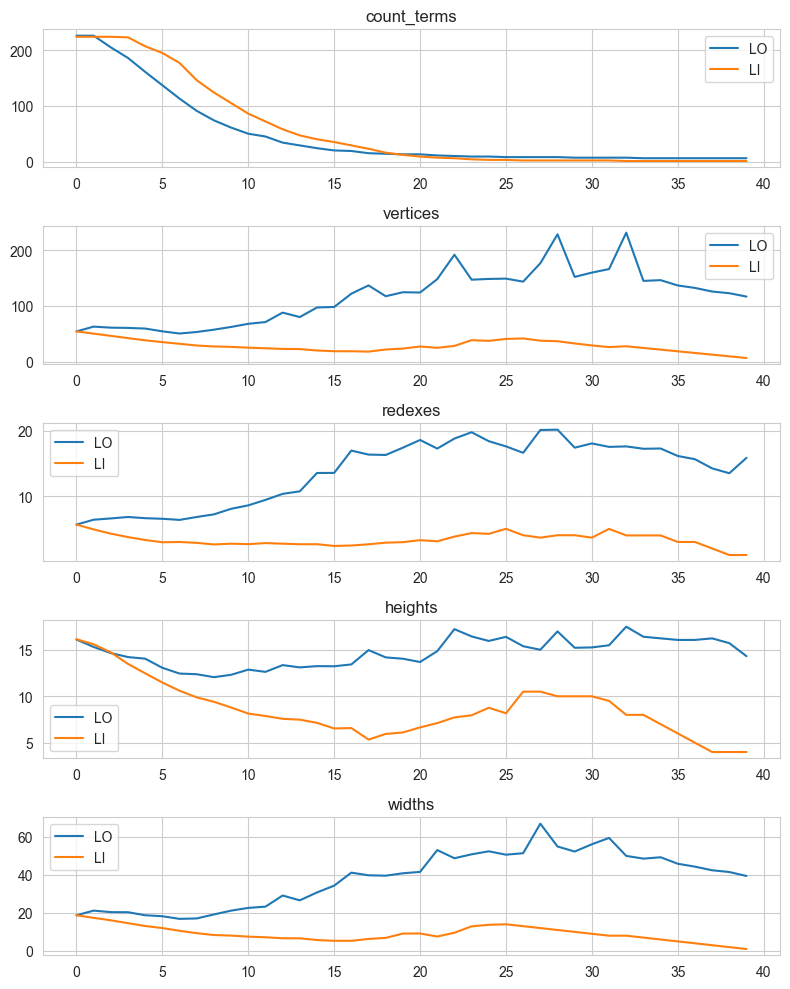

In [61]:
vis_df = {
    "count_terms": {
        "LO": data_vis_LO["count_terms"][:40],
        "LI": data_vis_LI["count_terms"][:40],
    },
    "vertices": {
        "LO": data_vis_LO["vertices"][:40],
        "LI": data_vis_LI["vertices"][:40],
    },
    "redexes": {
        "LO": data_vis_LO["redexes"][:40],
        "LI": data_vis_LI["redexes"][:40],
    },
    "heights": {
        "LO": data_vis_LO["heights"][:40],
        "LI": data_vis_LI["heights"][:40],
    },
    "widths": {
        "LO": data_vis_LO["widths"][:40],
        "LI": data_vis_LI["widths"][:40],
    },
}
plot_multi_multi_lines(vis_df)

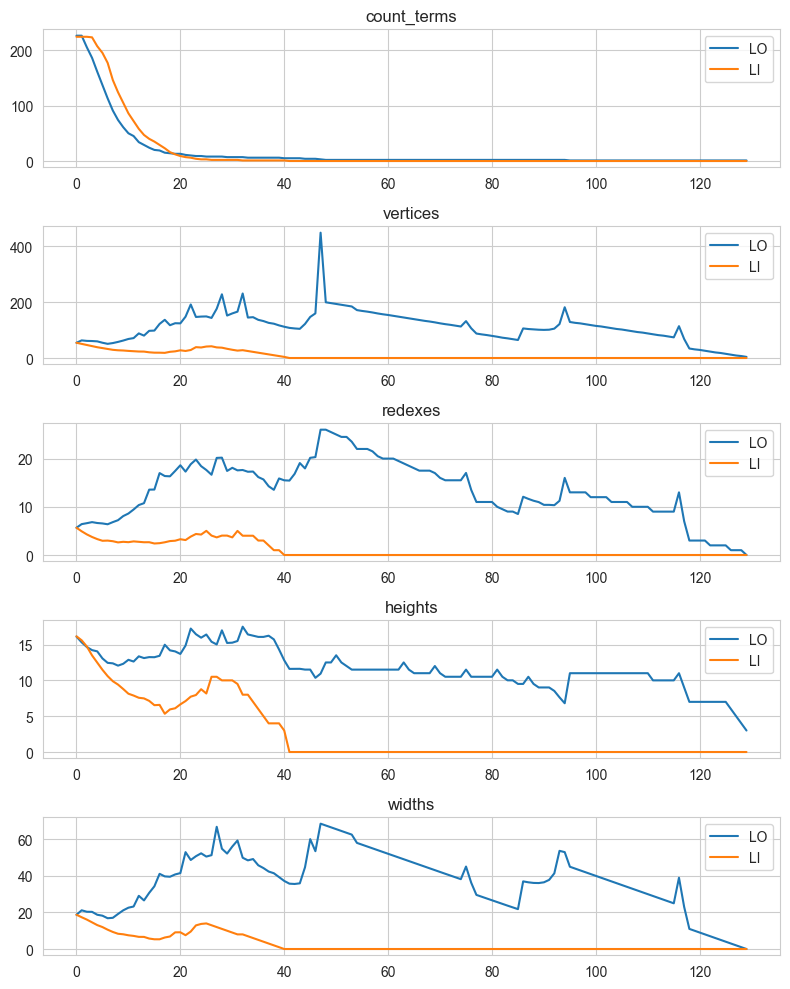

In [62]:
vis_df = {
    "count_terms": {
        "LO": data_vis_LO["count_terms"],
        "LI": data_vis_LI["count_terms"],
    },
    "vertices": {
        "LO": data_vis_LO["vertices"],
        "LI": data_vis_LI["vertices"],
    },
    "redexes": {
        "LO": data_vis_LO["redexes"],
        "LI": data_vis_LI["redexes"],
    },
    "heights": {
        "LO": data_vis_LO["heights"],
        "LI": data_vis_LI["heights"],
    },
    "widths": {
        "LO": data_vis_LO["widths"],
        "LI": data_vis_LI["widths"],
    },
}
plot_multi_multi_lines(vis_df)

# Visualize distribution with Ridge Plot

In [37]:
data_vis_LO = {"step": [], "step_count": [],
               "count_terms": [], "vertices": [], "redexes": [], "redex_depths": [],
               "redex_indexes": [], "heights": [], "widths": [], "steps_time": []}

params_lst = ["vertices", "redexes", "redex_depths", "redex_indexes", "heights", "widths", "steps_time"]
steps_lst = list(range(max([len(record["vertices"]) for record in data_LO])))

for step_no in steps_lst:
    count_terms = 0
    for term_params in data_LO:
        if term_params and step_no < len(term_params["vertices"]):
            count_terms += 1

    for term_params in data_LO:
        if term_params and step_no < len(term_params["vertices"]):
            for key_ in params_lst:
                data_vis_LO[key_].append(term_params[key_][step_no])
            data_vis_LO["step"].append(step_no)
            data_vis_LO["count_terms"].append(count_terms)
            data_vis_LO["step_count"].append(f"{step_no}) -> [{count_terms}]")

In [38]:
data_vis_LI = {"step": [], "step_count": [],
               "count_terms": [], "vertices": [], "redexes": [], "redex_depths": [],
               "redex_indexes": [], "heights": [], "widths": [], "steps_time": []}

params_lst = ["vertices", "redexes", "redex_depths", "redex_indexes", "heights", "widths", "steps_time"]
steps_lst = list(range(max([len(record["vertices"]) for record in data_LI if record])))

for step_no in steps_lst:
    count_terms = 0
    for term_params in data_LI:
        if term_params and step_no < len(term_params["vertices"]):
            count_terms += 1

    for term_params in data_LI:
        if term_params and step_no < len(term_params["vertices"]):
            for key_ in params_lst:
                data_vis_LI[key_].append(term_params[key_][step_no])
            data_vis_LI["step"].append(step_no)
            data_vis_LI["count_terms"].append(count_terms)
            data_vis_LI["step_count"].append(f"{step_no}) -> [{count_terms}]")

In [39]:
data_vis_LO_dct = data_vis_LO
data_vis_LI_dct = data_vis_LI

data_vis_LO = pd.DataFrame(data_vis_LO)
data_vis_LI = pd.DataFrame(data_vis_LI)

# "vertices"
# "redexes"
# "redex_depths"
# "redex_indexes"
# "heights"
# "widths"
# "steps_time"

In [40]:
def draw_single_ridgeline_plot(
        data_vis, data_decr="LO norm",
        fist_step_no=0, last_step_no=20,
        vis_data_name="vertices", vis_data_lim=100,
):
    selected_data = [fist_step_no <= step_no < last_step_no for step_no in data_vis["step"]]
    tmp_data_vis = data_vis[selected_data].copy(deep=True)
    # cat_steps = pd.api.types.CategoricalDtype(list(range(fist_step_no, last_step_no)))
    # tmp_data_vis['step'] = tmp_data_vis['step'].astype(cat_steps)
    cat_steps = []
    for var_ in list(tmp_data_vis['step_count']):
        if var_ not in cat_steps:
            cat_steps.append(var_)
    cat_steps = pd.api.types.CategoricalDtype(cat_steps)
    tmp_data_vis['step_count'] = tmp_data_vis['step_count'].astype(cat_steps)
    if vis_data_lim:
        tmp_data_vis = tmp_data_vis[[rec_ < vis_data_lim for rec_ in tmp_data_vis[vis_data_name]]]

    plt.figure()

    joyplot(
        data=tmp_data_vis[[vis_data_name, 'step_count']],
        by='step_count',
        figsize=(12, 8),
    )
    plt.title(f"Ridgeline Plot {vis_data_name} for {data_decr}", fontsize=20)
    plt.show()

<Figure size 640x480 with 0 Axes>

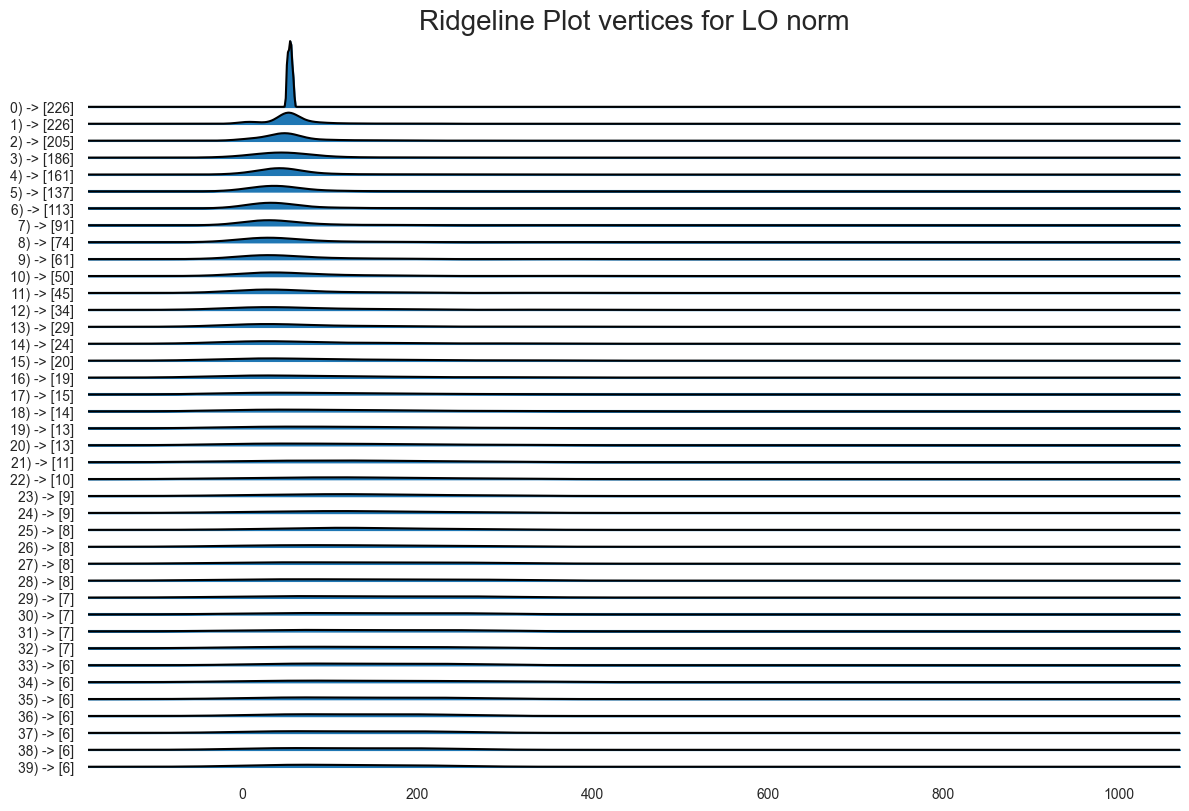

In [41]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LO, data_decr="LO norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="vertices", vis_data_lim=None,
)

<Figure size 640x480 with 0 Axes>

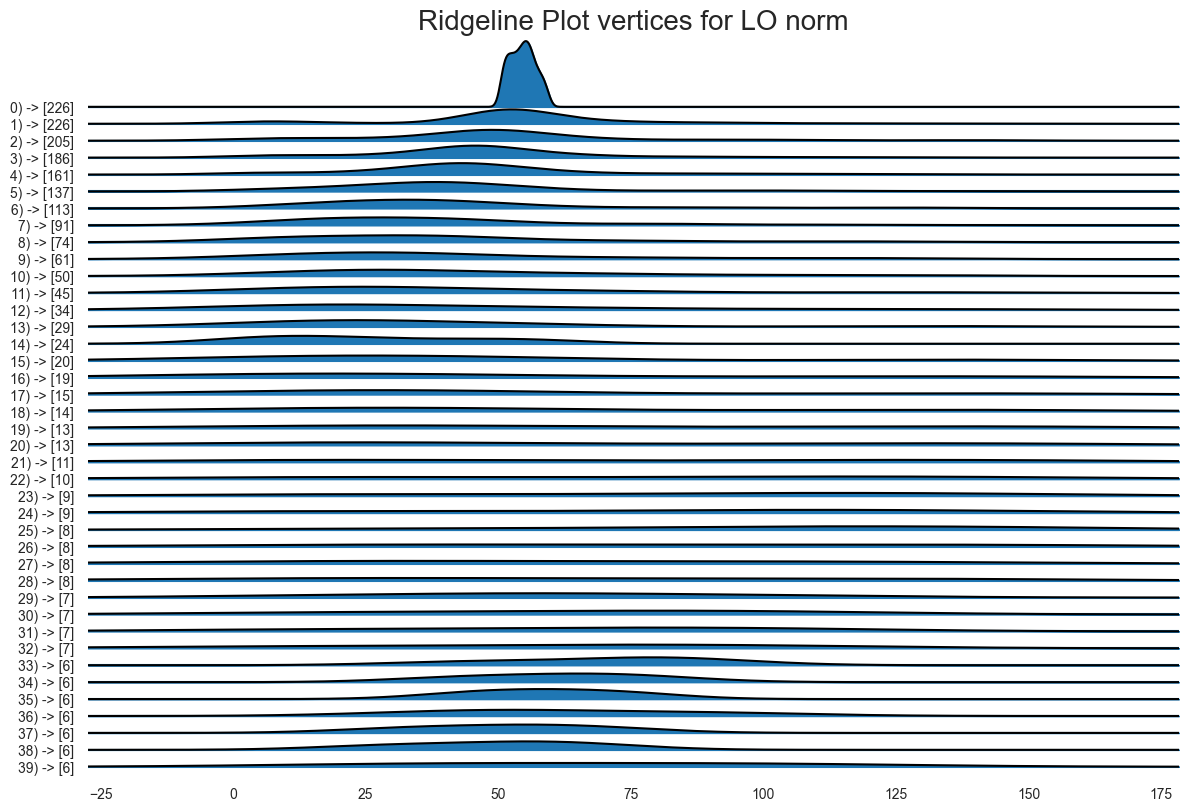

In [42]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LO, data_decr="LO norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="vertices", vis_data_lim=150,
)

<Figure size 640x480 with 0 Axes>

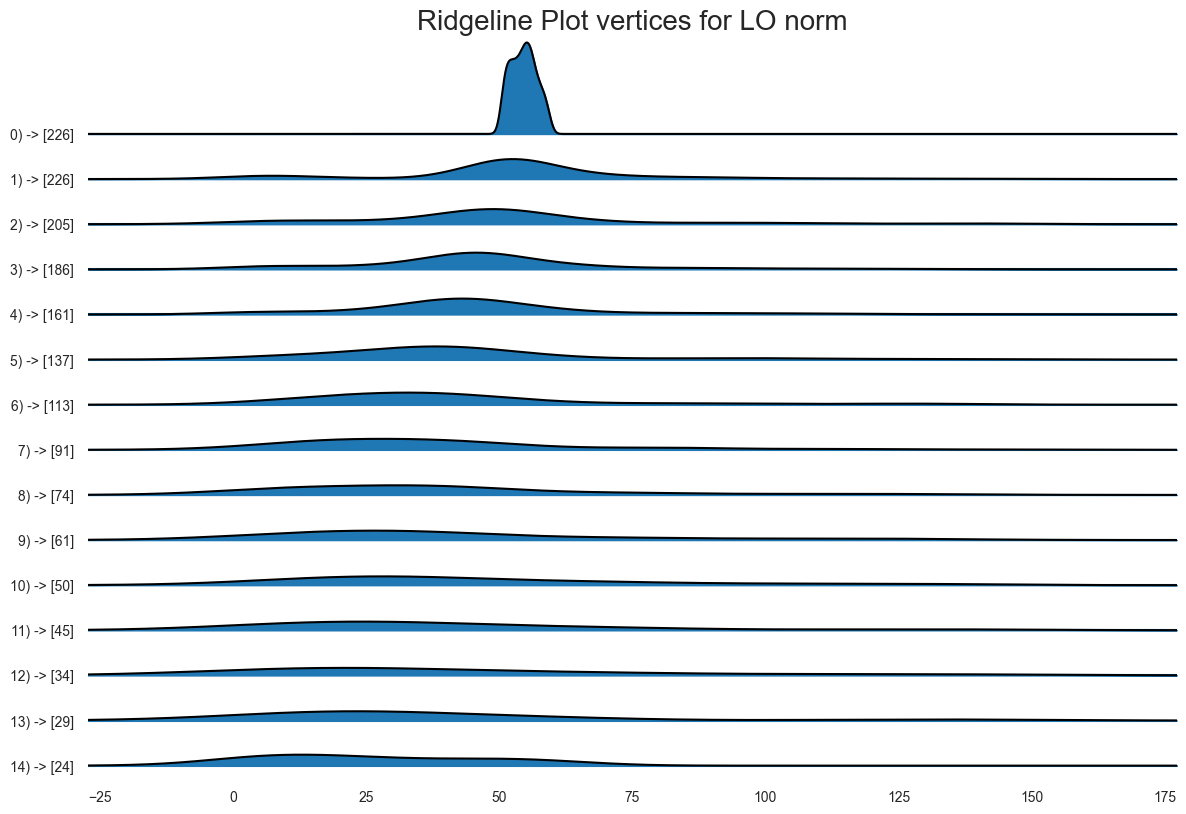

In [43]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LO, data_decr="LO norm",
    fist_step_no=0, last_step_no=15,
    vis_data_name="vertices", vis_data_lim=150,
)

<Figure size 640x480 with 0 Axes>

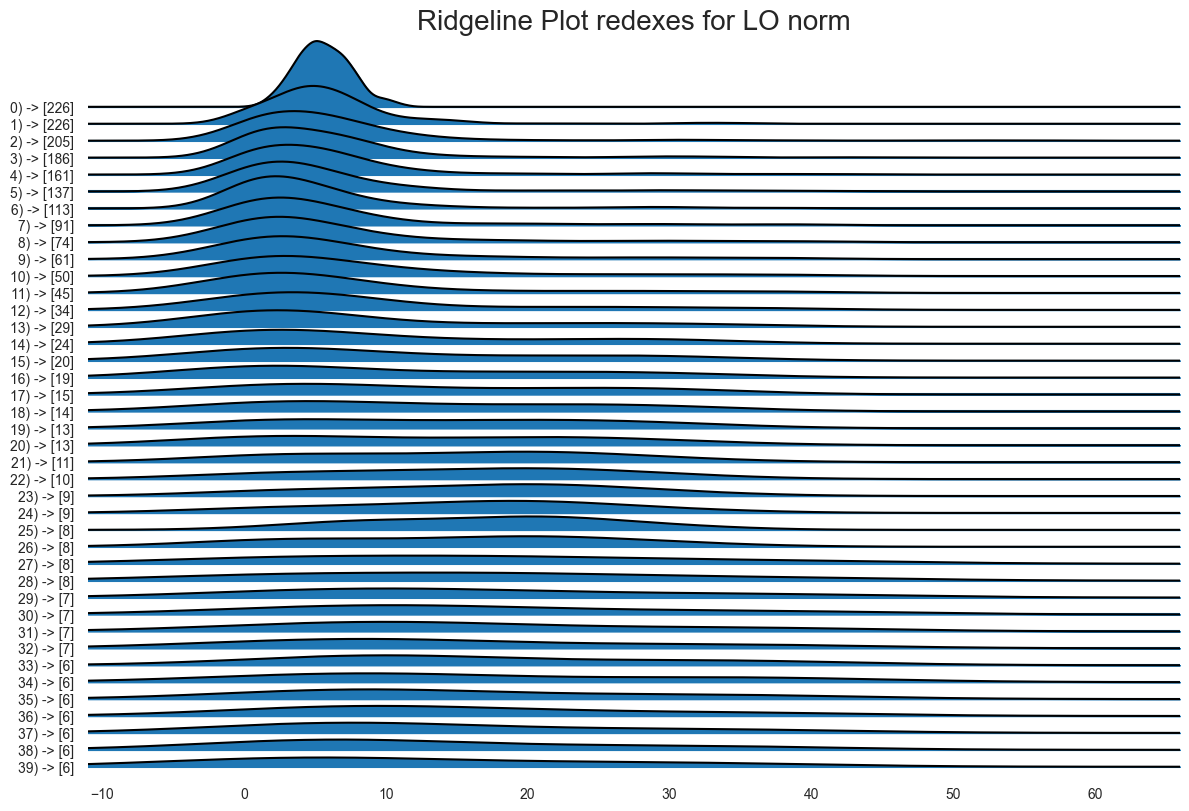

In [44]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LO, data_decr="LO norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="redexes", vis_data_lim=60,
)

<Figure size 640x480 with 0 Axes>

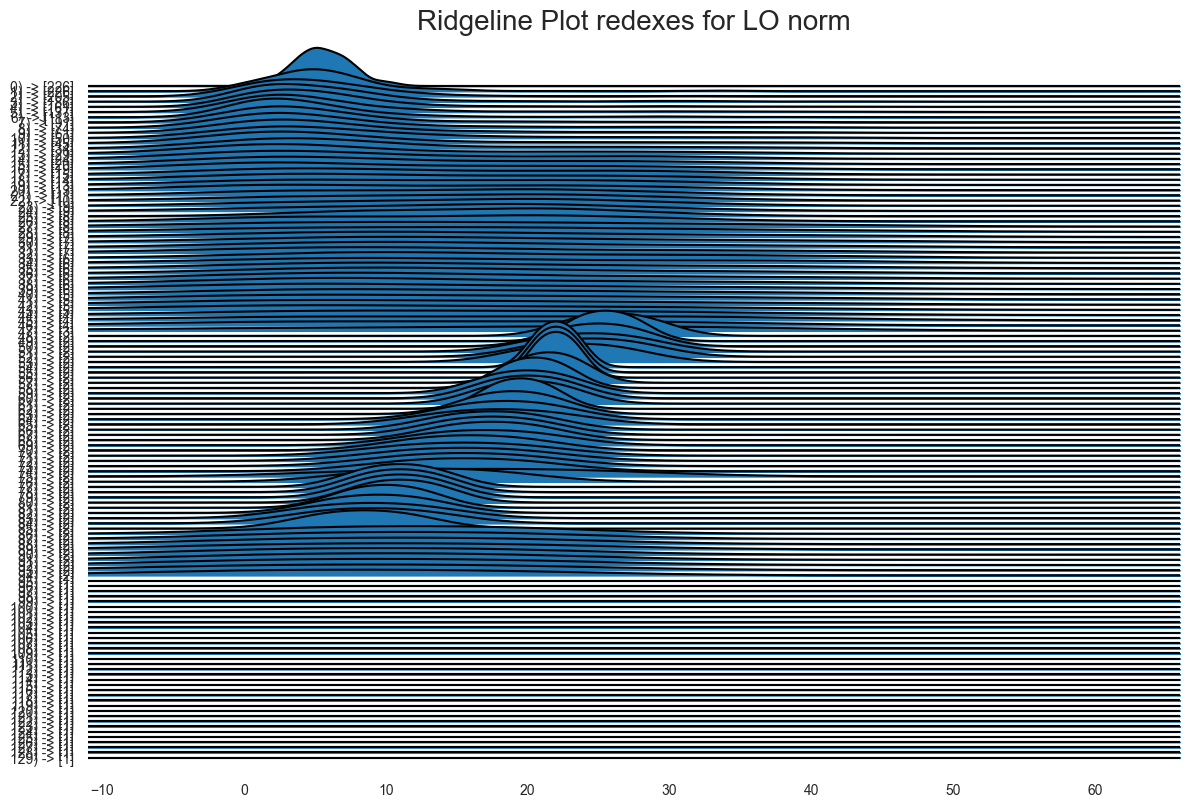

In [96]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LO, data_decr="LO norm",
    fist_step_no=0, last_step_no=400,
    vis_data_name="redexes", vis_data_lim=60,
)

<Figure size 640x480 with 0 Axes>

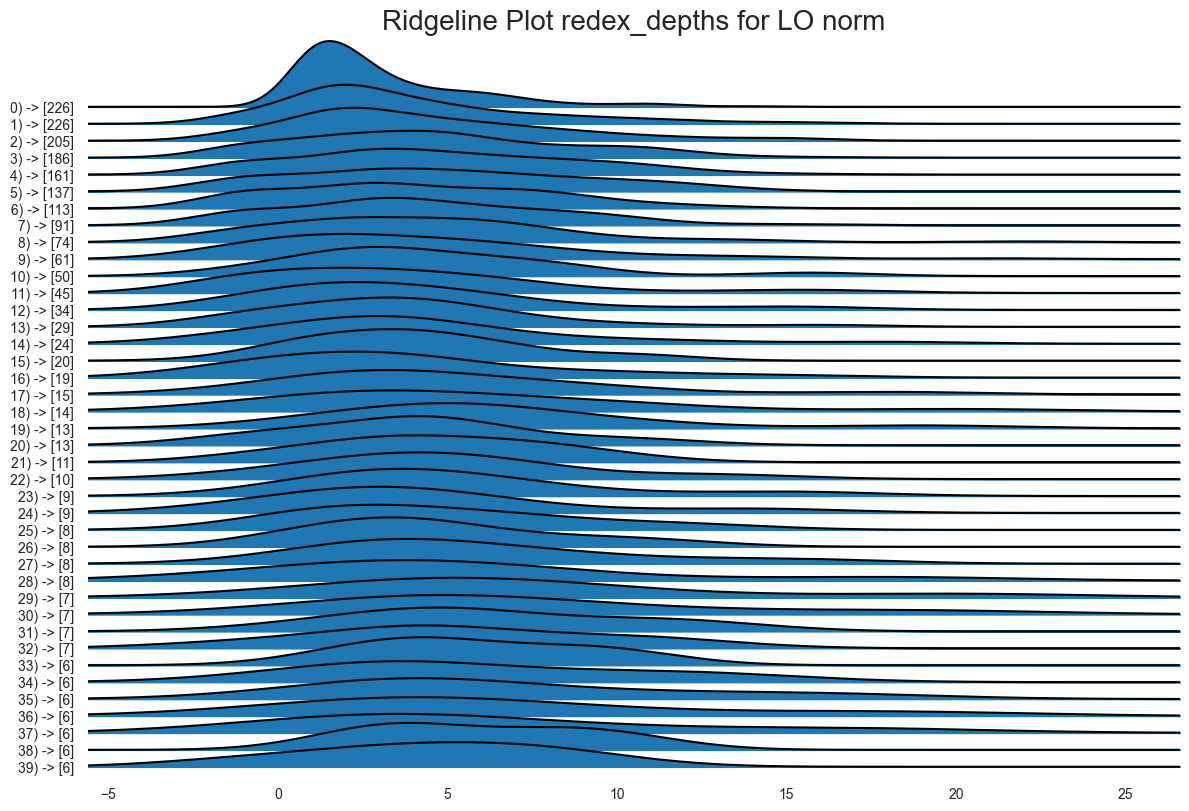

In [45]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LO, data_decr="LO norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="redex_depths", vis_data_lim=None,
)

<Figure size 640x480 with 0 Axes>

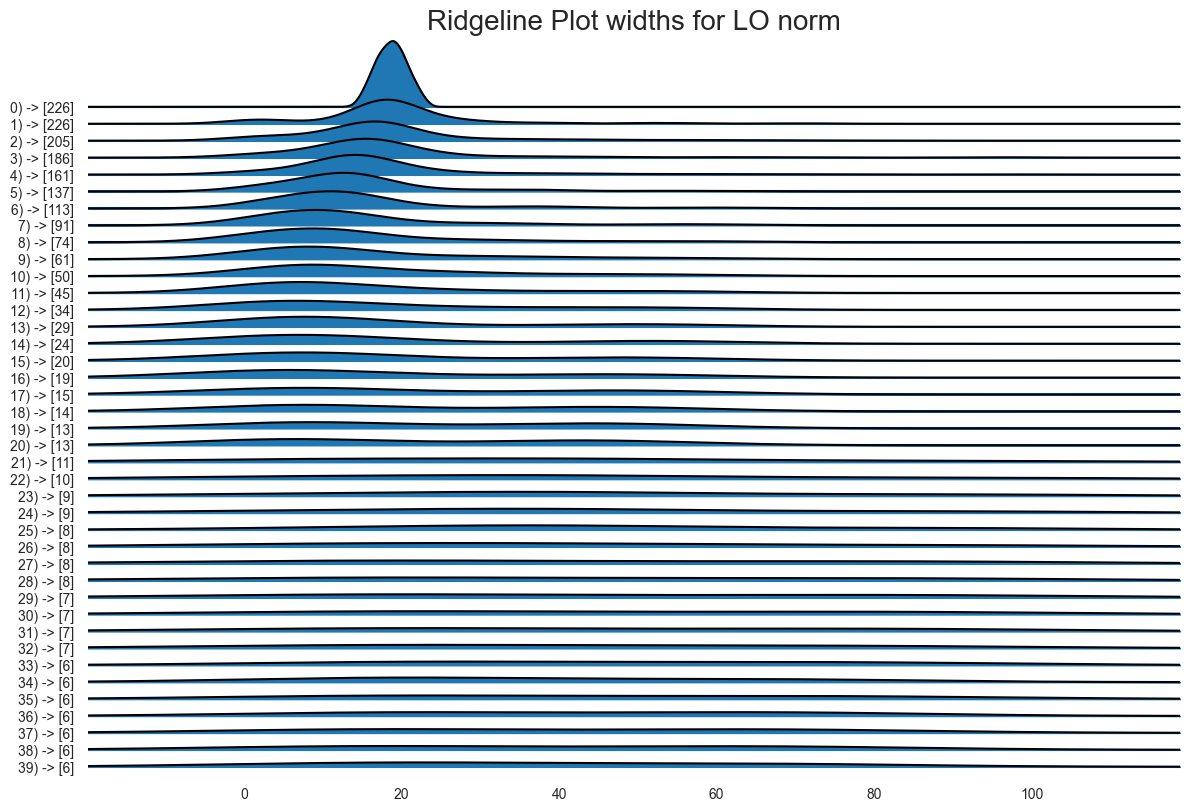

In [46]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LO, data_decr="LO norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="widths", vis_data_lim=100,
)

<Figure size 640x480 with 0 Axes>

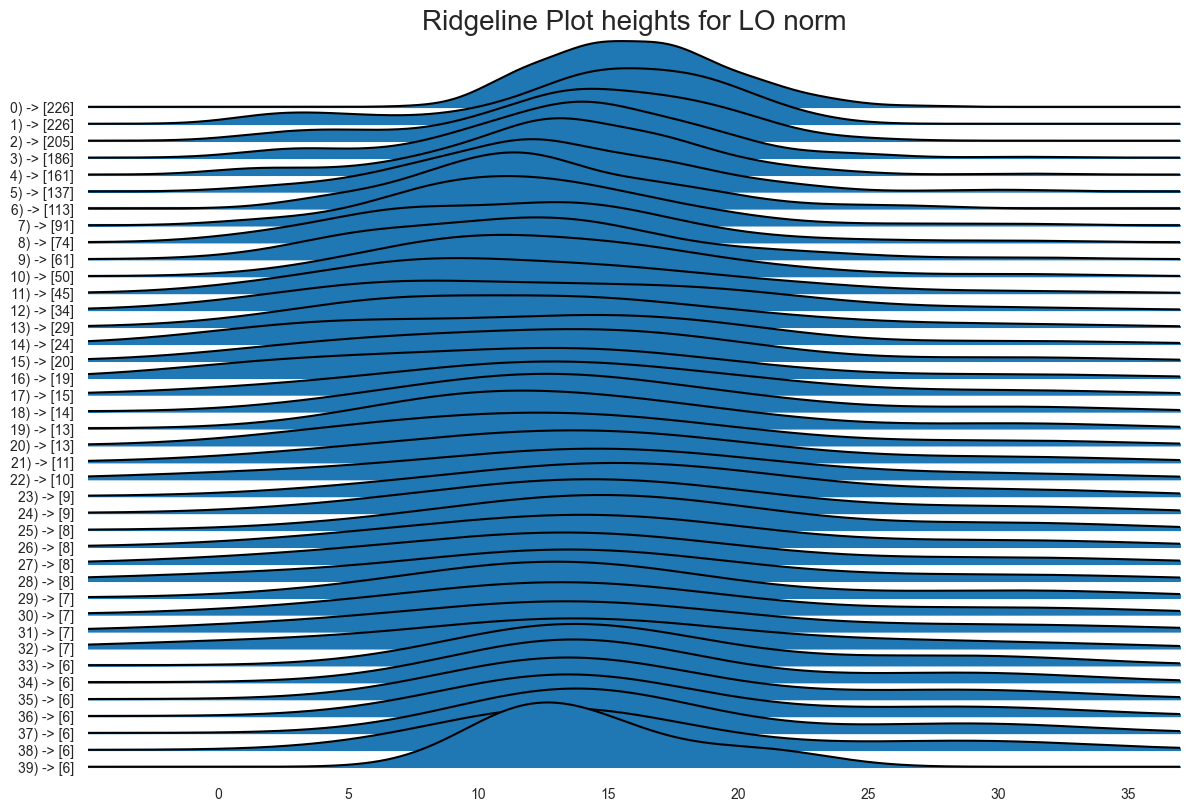

In [47]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LO, data_decr="LO norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="heights", vis_data_lim=None,
)

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\joypy\joyplot.py:286: UserWarning: The data contains a group with a single distinct value (0.0) having infinite probability density. Consider using a different visualization.
  warnings.warn("The data contains a group with a single distinct value ({}) "


<Figure size 640x480 with 0 Axes>

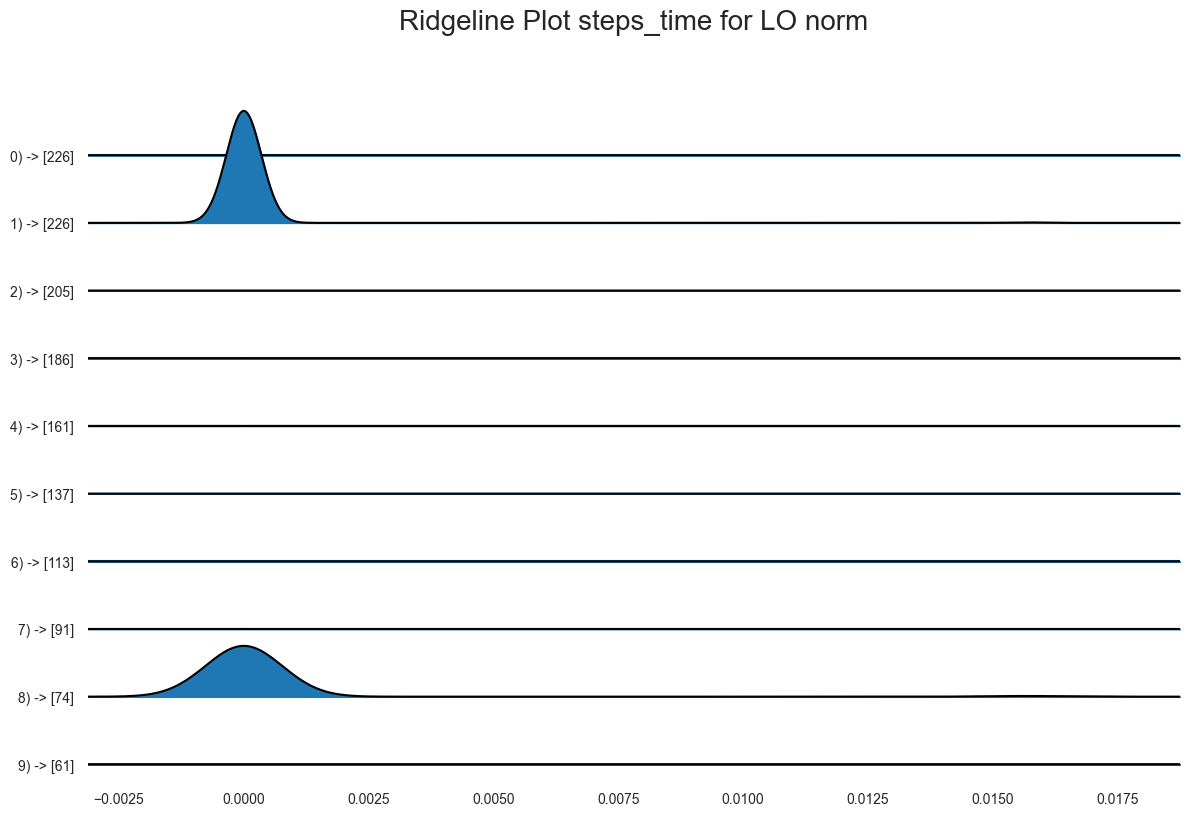

In [49]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LO, data_decr="LO norm",
    fist_step_no=0, last_step_no=10,
    vis_data_name="steps_time", vis_data_lim=None,
)

# Ridgeline Plot for LI data

<Figure size 640x480 with 0 Axes>

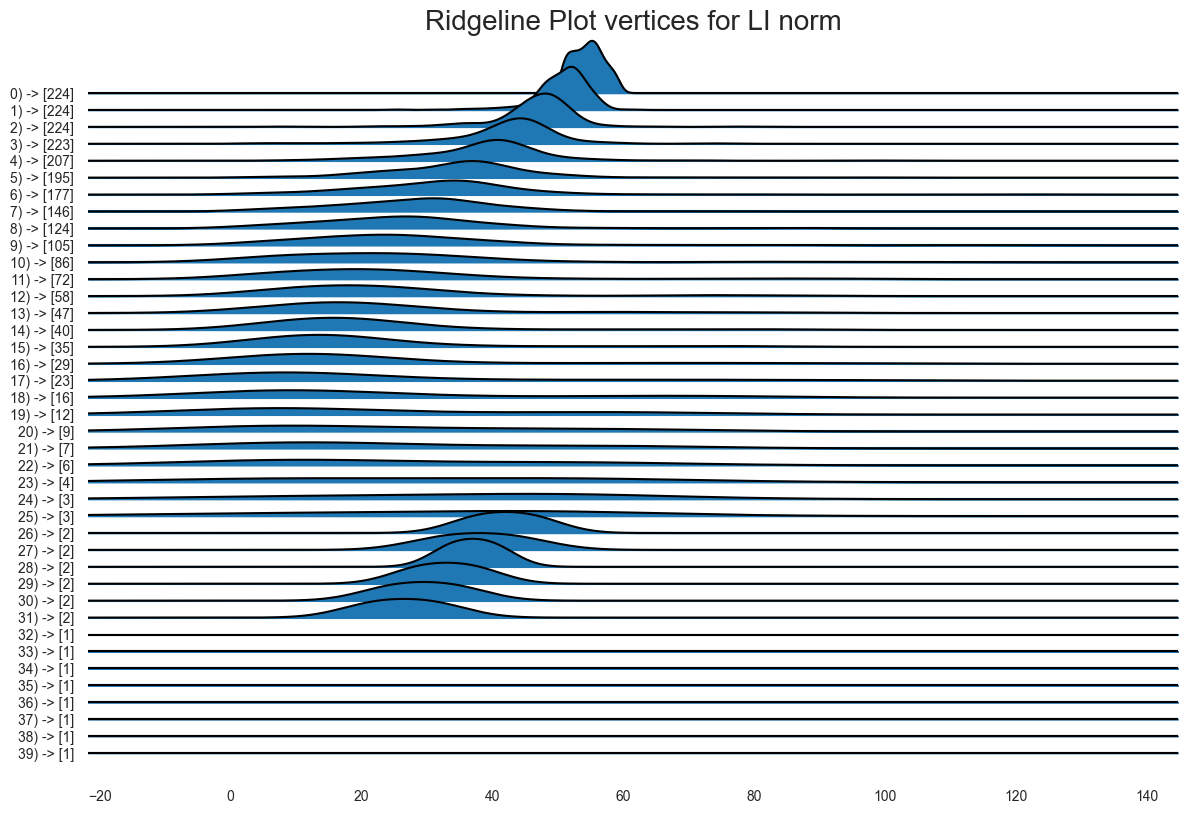

In [50]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LI, data_decr="LI norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="vertices", vis_data_lim=None,
)

<Figure size 640x480 with 0 Axes>

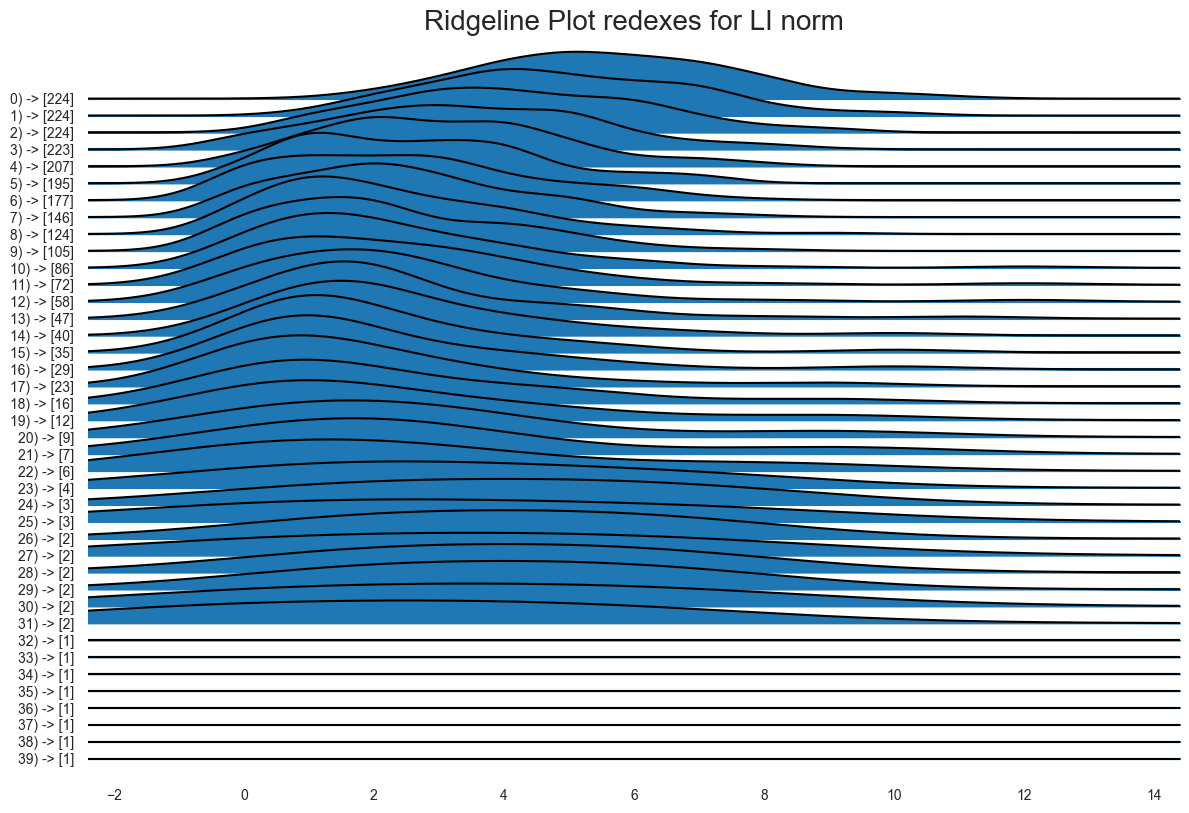

In [51]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LI, data_decr="LI norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="redexes", vis_data_lim=None,
)

<Figure size 640x480 with 0 Axes>

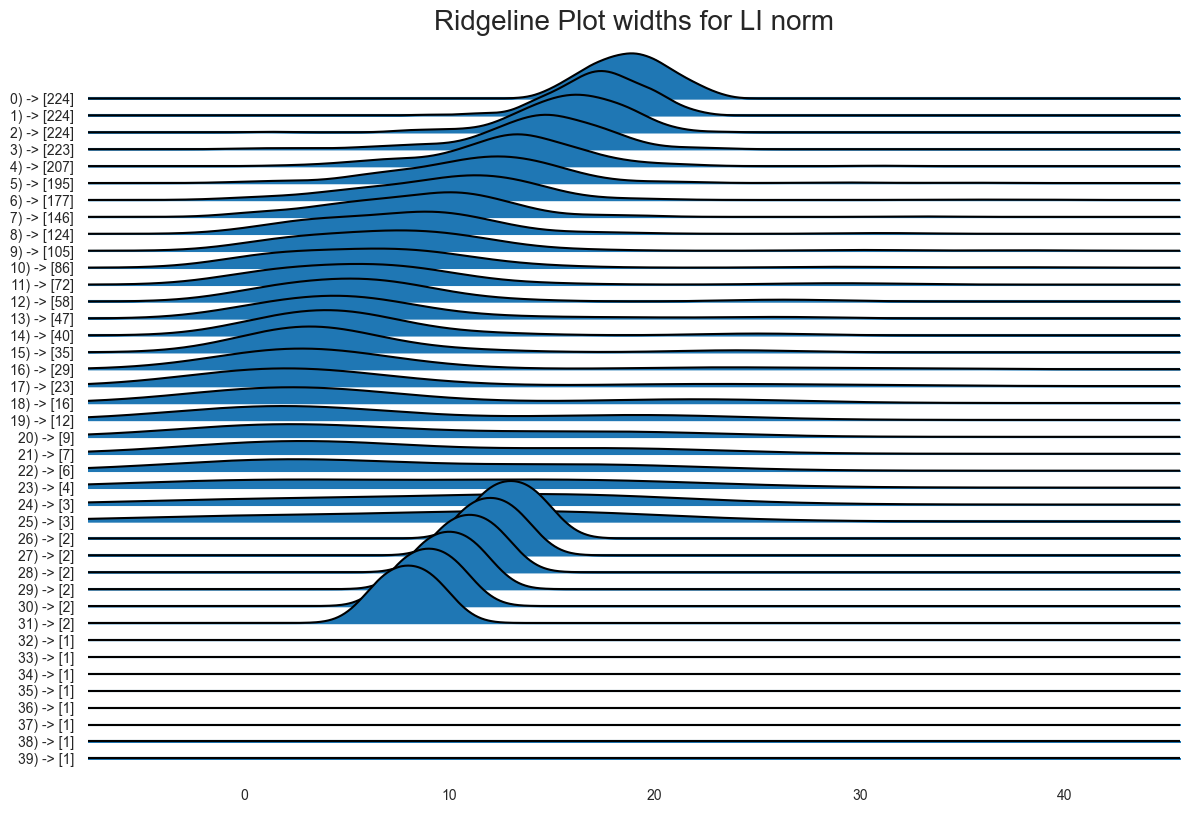

In [52]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LI, data_decr="LI norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="widths", vis_data_lim=None,
)

<Figure size 640x480 with 0 Axes>

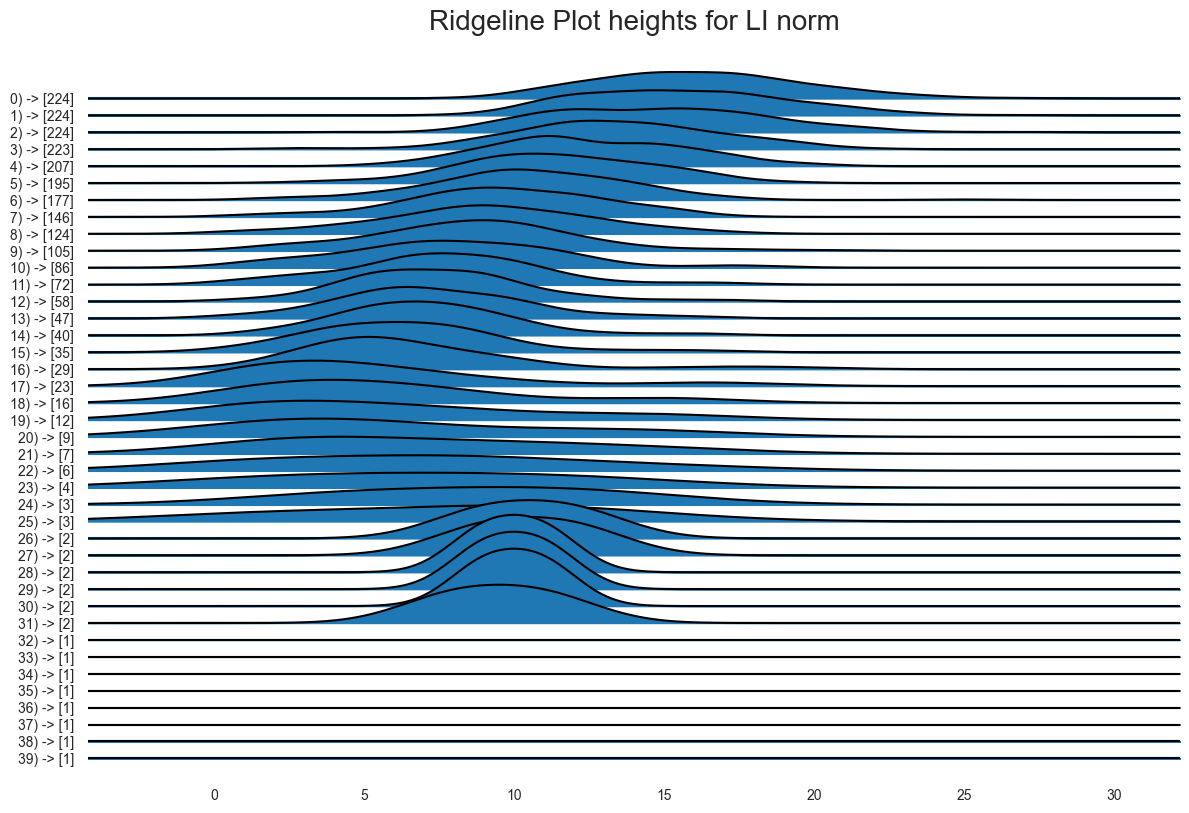

In [53]:
draw_single_ridgeline_plot(
    data_vis=data_vis_LI, data_decr="LI norm",
    fist_step_no=0, last_step_no=40,
    vis_data_name="heights", vis_data_lim=None,
)

# Visualize both LO & LI

In [121]:
data_vis_comb_LI_LO = {
    "step": [], "step_count": [],
    "count_terms_LO": [], "vertices_LO": [], "redexes_LO": [], "redex_depths_LO": [],
    "redex_indexes_LO": [], "heights_LO": [], "widths_LO": [], "steps_time_LO": [],
    "count_terms_LI": [], "vertices_LI": [], "redexes_LI": [], "redex_depths_LI": [],
    "redex_indexes_LI": [], "heights_LI": [], "widths_LI": [], "steps_time_LI": []
}

params_lst = ["vertices", "redexes", "redex_depths", "redex_indexes", "heights", "widths", "steps_time"]
steps_lst = list(range(max(
    max([len(record["vertices"]) for record in data_LO if record]),
    max([len(record["vertices"]) for record in data_LI if record])
)))

global_inx = 0
for step_no in steps_lst:
    step_data_vis_LO = data_vis_LO[[step_no_ == step_no for step_no_ in data_vis_LO["step"]]].reset_index(drop=True).to_dict()
    step_data_vis_LI = data_vis_LI[[step_no_ == step_no for step_no_ in data_vis_LI["step"]]].reset_index(drop=True).to_dict()

    for inx in range(min(len(step_data_vis_LO["step"]), len(step_data_vis_LI["step"]))):
        data_vis_comb_LI_LO["step"].append(step_no)

        if inx < len(step_data_vis_LO["step"]):
            for key_ in params_lst:
                data_vis_comb_LI_LO[key_ + "_LO"].append(step_data_vis_LO[key_][inx])
            data_vis_comb_LI_LO["count_terms_LO"].append(step_data_vis_LO["count_terms"][inx])
        else:
            for key_ in params_lst:
                data_vis_comb_LI_LO[key_ + "_LO"].append(None)
            data_vis_comb_LI_LO["count_terms_LO"].append(data_vis_comb_LI_LO["count_terms_LO"][-1])

        if inx < len(step_data_vis_LI["step"]):
            for key_ in params_lst:
                data_vis_comb_LI_LO[key_ + "_LI"].append(step_data_vis_LI[key_][inx])
            data_vis_comb_LI_LO["count_terms_LI"].append(step_data_vis_LI["count_terms"][inx])
        else:
            for key_ in params_lst:
                data_vis_comb_LI_LO[key_ + "_LI"].append(None)
            data_vis_comb_LI_LO["count_terms_LI"].append(data_vis_comb_LI_LO["count_terms_LI"][-1])

        data_vis_comb_LI_LO["step_count"].append(
            f"{step_no} -> LO_[{data_vis_comb_LI_LO['count_terms_LO'][global_inx]}] LI_[{data_vis_comb_LI_LO['count_terms_LI'][global_inx]}]")
        global_inx += 1

data_vis_comb_LI_LO = pd.DataFrame(data_vis_comb_LI_LO)

In [122]:
data_vis_comb_LI_LO.head()

step              step_count  count_terms_LO  vertices_LO  redexes_LO  \
0     0  0 -> LO_[226] LI_[224]             226           53           3   
1     0  0 -> LO_[226] LI_[224]             226           54           6   
2     0  0 -> LO_[226] LI_[224]             226           56           6   
3     0  0 -> LO_[226] LI_[224]             226           51           2   
4     0  0 -> LO_[226] LI_[224]             226           51           5   

   redex_depths_LO  redex_indexes_LO  heights_LO  widths_LO  steps_time_LO  \
0                1                 1          15         21            0.0   
1                2                 2          13         17            0.0   
2                2                 2          18         22            0.0   
3                6                 6          14         19            0.0   
4                3                 3          11         17            0.0   

   count_terms_LI  vertices_LI  redexes_LI  redex_depths_LI  redex_indexes_LI  \
0             224           53           3                4                12   
1             224           54           6                7                10   
2             224           56           6                7                 7   
3             224           51           2                9                 9   
4             224           51           5                8                22   

   heights_LI  widths_LI  steps_time_LI  
0          15         21            0.0  
1          13         17            0.0  
2          18         22            0.0  
3          14         19            0.0  
4          11         17            0.0

In [123]:
def draw_two_ridgeline_plot(
        data_vis, data_decr="LO vs LI norm",
        fist_step_no=0, last_step_no=20,
        vis_data_name_0="vertices_LO", vis_data_name_1="vertices_LI",
        vis_data_lim_0=100, vis_data_lim_1=100,
):
    selected_data = [fist_step_no <= step_no_ < last_step_no for step_no_ in data_vis["step"]]
    tmp_data_vis = data_vis[selected_data].copy(deep=True)
    cat_steps = []
    for var_ in list(tmp_data_vis['step_count']):
        if var_ not in cat_steps:
            cat_steps.append(var_)
    cat_steps = pd.api.types.CategoricalDtype(cat_steps)
    tmp_data_vis['step_count'] = tmp_data_vis['step_count'].astype(cat_steps)
    if vis_data_lim_0:
        tmp_data_vis = tmp_data_vis[[rec_ < vis_data_lim_0 for rec_ in tmp_data_vis[vis_data_name_0]]]

    if vis_data_lim_1:
        tmp_data_vis = tmp_data_vis[[rec_ < vis_data_lim_1 for rec_ in tmp_data_vis[vis_data_name_1]]]

    plt.figure()

    joyplot(
        data=tmp_data_vis[[vis_data_name_0, vis_data_name_1, 'step_count']],
        by='step_count',
        column=[vis_data_name_0, vis_data_name_1],
        color=['#686de0', '#eb4d4b'],
        legend=True,
        alpha=0.85,
        figsize=(12, 8)
    )

    plt.title(f"Ridgeline Plot {vis_data_name_0} & {vis_data_name_1} for {data_decr}", fontsize=20)
    plt.show()

<Figure size 640x480 with 0 Axes>

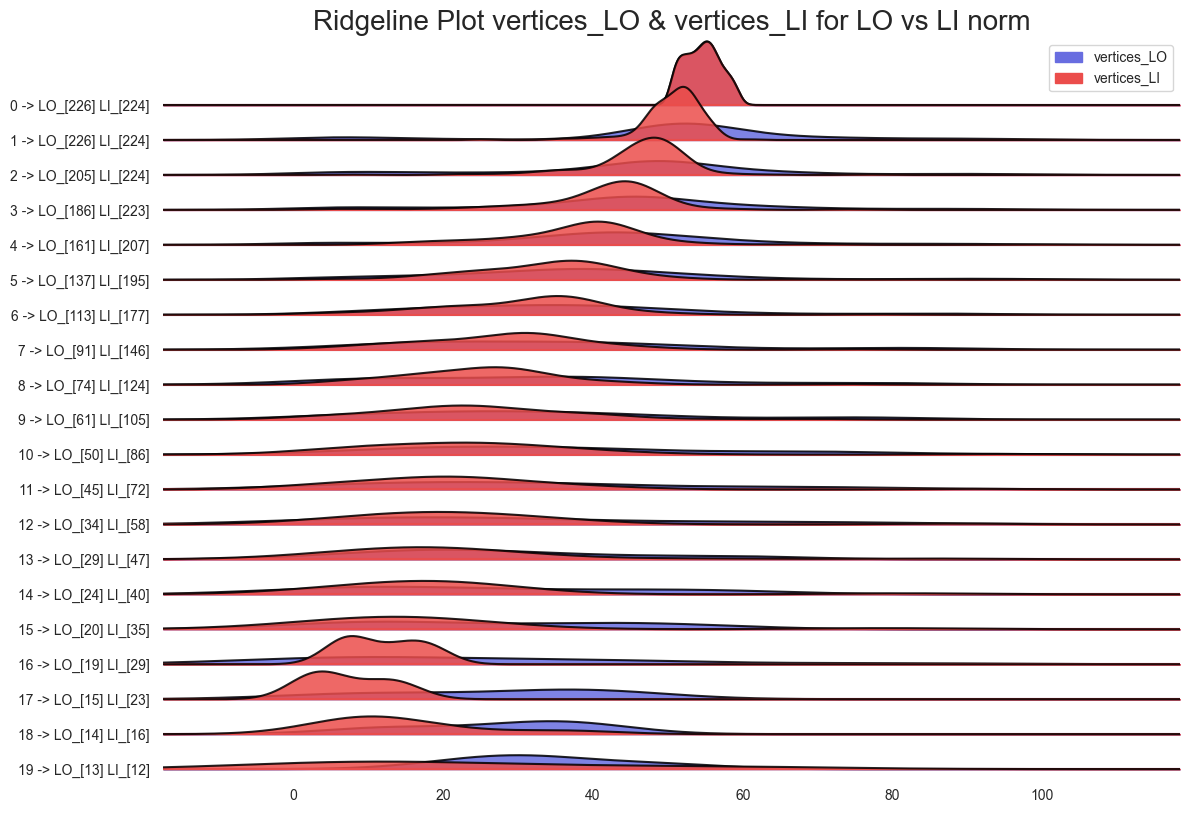

In [128]:
draw_two_ridgeline_plot(
    data_vis=data_vis_comb_LI_LO, data_decr="LO vs LI norm",
    fist_step_no=0, last_step_no=20,
    vis_data_name_0="vertices_LO", vis_data_name_1="vertices_LI",
    vis_data_lim_0=100, vis_data_lim_1=100,
)

<Figure size 640x480 with 0 Axes>

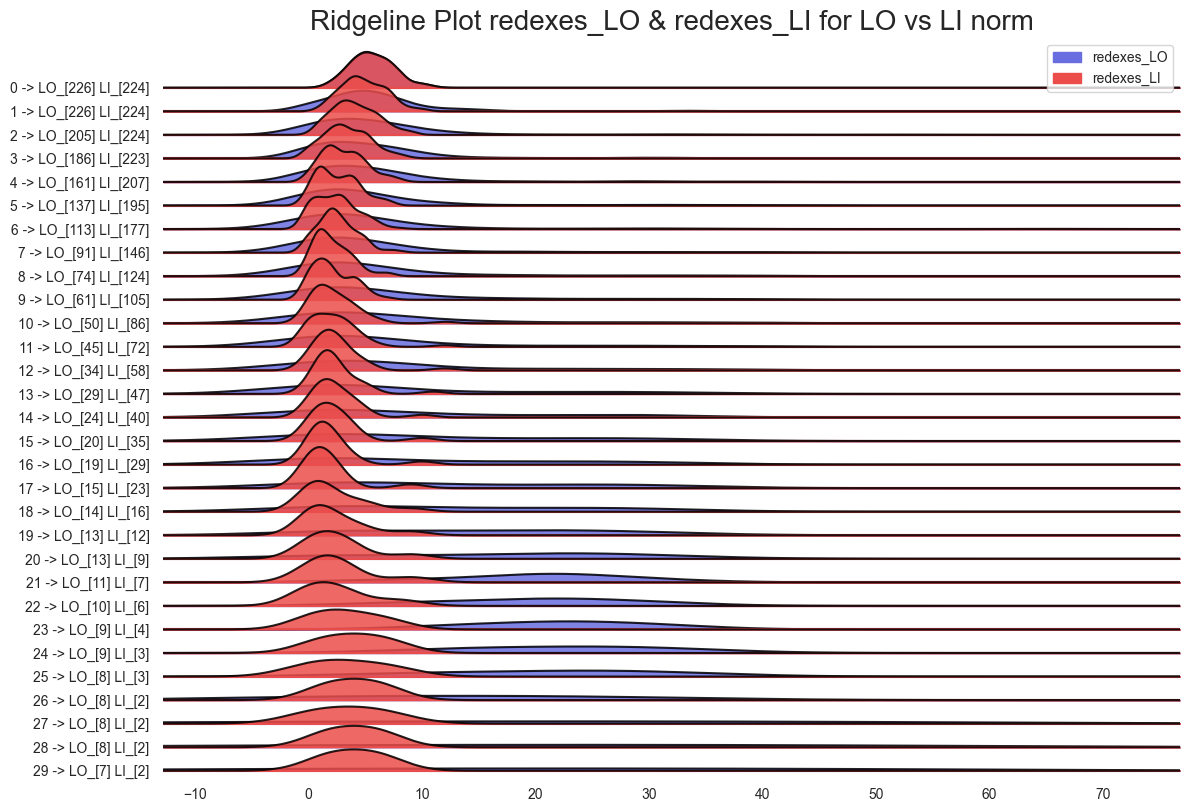

In [129]:
draw_two_ridgeline_plot(
    data_vis=data_vis_comb_LI_LO, data_decr="LO vs LI norm",
    fist_step_no=0, last_step_no=30,
    vis_data_name_0="redexes_LO", vis_data_name_1="redexes_LI",
    vis_data_lim_0=100, vis_data_lim_1=100,
)

<Figure size 640x480 with 0 Axes>

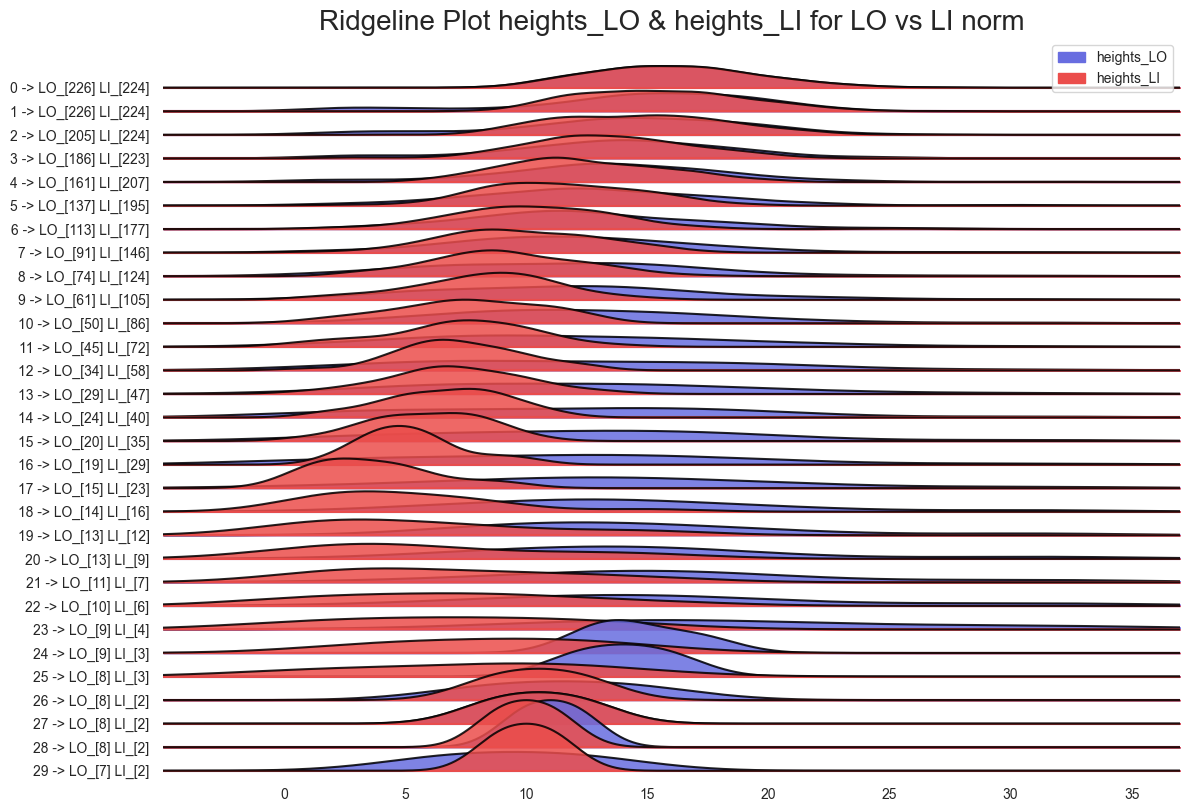

In [130]:
draw_two_ridgeline_plot(
    data_vis=data_vis_comb_LI_LO, data_decr="LO vs LI norm",
    fist_step_no=0, last_step_no=30,
    vis_data_name_0="heights_LO", vis_data_name_1="heights_LI",
    vis_data_lim_0=None, vis_data_lim_1=None,
)

<Figure size 640x480 with 0 Axes>

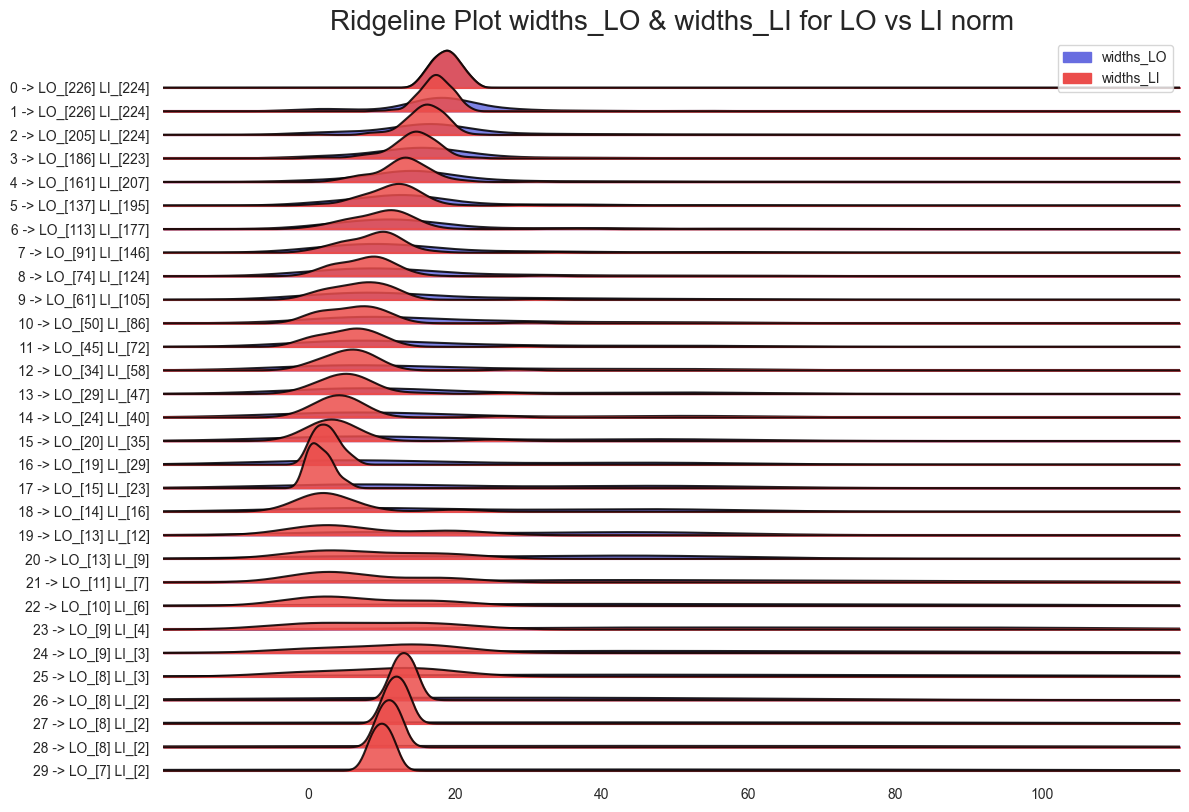

In [132]:
draw_two_ridgeline_plot(
    data_vis=data_vis_comb_LI_LO, data_decr="LO vs LI norm",
    fist_step_no=0, last_step_no=30,
    vis_data_name_0="widths_LO", vis_data_name_1="widths_LI",
    vis_data_lim_0=100, vis_data_lim_1=100,
)

<Figure size 640x480 with 0 Axes>

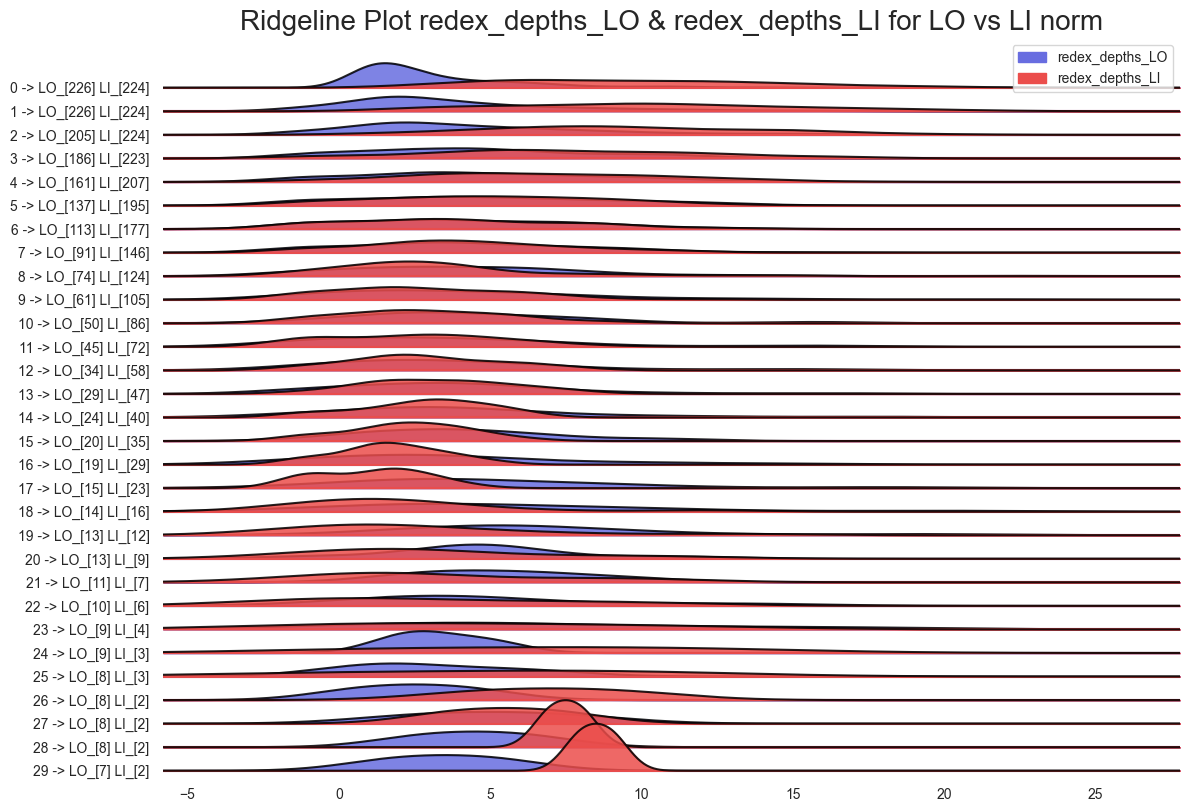

In [134]:
draw_two_ridgeline_plot(
    data_vis=data_vis_comb_LI_LO, data_decr="LO vs LI norm",
    fist_step_no=0, last_step_no=30,
    vis_data_name_0="redex_depths_LO", vis_data_name_1="redex_depths_LI",
    vis_data_lim_0=None, vis_data_lim_1=None,
)